## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader

from utils import print_shape_dtype, get_file_path

save_dir = 'your save directory path'
os.makedirs(save_dir, exist_ok=True)
EXP_NAME="your experiment name"

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

## Plot Config For Figure

In [2]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

## Config
This is hyper-parameter of training. 

In [3]:
PROJECT_NAME= 'kaggle_sign'
PREPROCESS_DATA = False
TRAIN_MODEL = True

USE_VAL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250


INPUT_SIZE = 64

LABEL_SMOOTHING = 0.50
TRAIN_BATCH_SIZE = 1000
VAL_BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
SWA_START = 70
SWA_LR = 1e-4
SWA_ANNEAL_EPOCH = 5
WD_RATIO = 1e-5
MASK_VAL = 4237

## For Deterministic Algorithm

In [4]:
deterministic = True

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

## Train

In [7]:
# Read Training Data

train = pd.read_csv('/opt/sign/challenge-template/data/csv/train.csv')

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 94477


## Add File Path

In [8]:
train['file_path'] = train['path'].apply(get_file_path)

## Ordinally Encode Sign

In [9]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

## IDX of Each Body parts
You do not have to use all idx in all body parts. I used below idxs. \
In my observation, this asl-sign data was created from videos taken with one hand holding the camera, so only the data from one hand was used for training. \
In details, I sampled only left parts to reduce unnecessary idxs from all parts. 

In [10]:
START_IDX = 468
SLIPS_IDXS0 = np.array([
        8, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
        191, 80, 81, 82, 13, 312, 311, 310, 415,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LEFT_EYE_IDXS0 = np.array([33, 7, 163, 144, 145, 153, 154, 155, 133,
                            246, 161, 160, 159, 158, 157, 173])
RIGIT_EYE_IDXS0 = np.array([263, 249, 390, 373, 374, 380, 381, 382, 362,
                            466, 388, 387, 386, 385, 384, 398])
NOSE_IDXS0 = np.array([1,2,98,327])


LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((SLIPS_IDXS0, LEFT_EYE_IDXS0, NOSE_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((SLIPS_IDXS0, RIGIT_EYE_IDXS0, NOSE_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size

# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, SLIPS_IDXS0)).squeeze()
EYE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_EYE_IDXS0)).squeeze()
NOSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, NOSE_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [11]:
LIPS_START = 0
EYE_START = LIPS_IDXS.size
NOSE_START = EYE_START + EYE_IDXS.size
LEFT_HAND_START = NOSE_START + NOSE_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, EYE_START: {EYE_START}, NOSE_START: {NOSE_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, EYE_START: 20, NOSE_START: 36, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


## Process Data TensorFlow

In [12]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)


In [13]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(EYE_IDXS) + [0.50] * len(NOSE_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            print(data)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
            print(data)
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
# preprocess_layer = PreprocessLayer()

## Interpolate NaN Values

In [14]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

## Create Dataset

In [15]:
# Get the full dataset
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        # Log message every 5000 samples
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [16]:
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    preprocess_data()
    ROOT_DIR = '.'
else:
    ROOT_DIR = '.'
    
# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train 
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

X_train shape: (80229, 64, 66, 3), dtype: float32
y_train shape: (80229,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (80229, 64), dtype: float32
X_val shape: (14248, 64, 66, 3), dtype: float32
y_val shape: (14248,), dtype: int32
NON_EMPTY_FRAME_IDXS_VAL shape: (14248, 64), dtype: float32
# NaN Values X_train: 0


## Number of Frames

  0%|          | 0/64 [00:00<?, ?it/s]

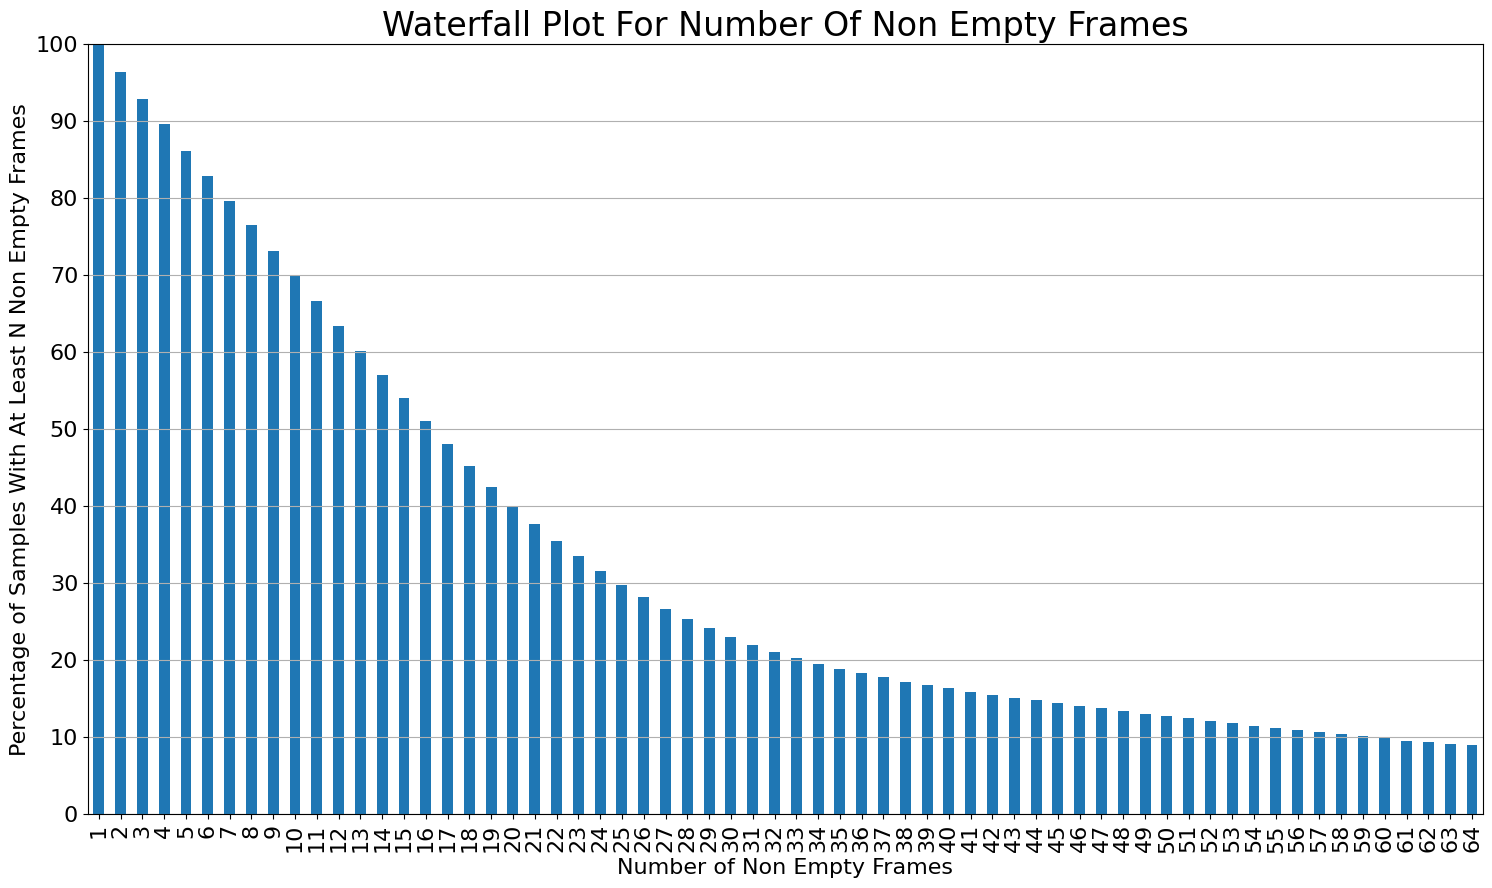

In [17]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1) 
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

## Percentage of Frames Filled

In [18]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 33.59%


## Feature Statistics -Lips

In [19]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

P_LEFT_LIPS_MEASUREMENTS: 99.34%


  0%|          | 0/20 [00:00<?, ?it/s]

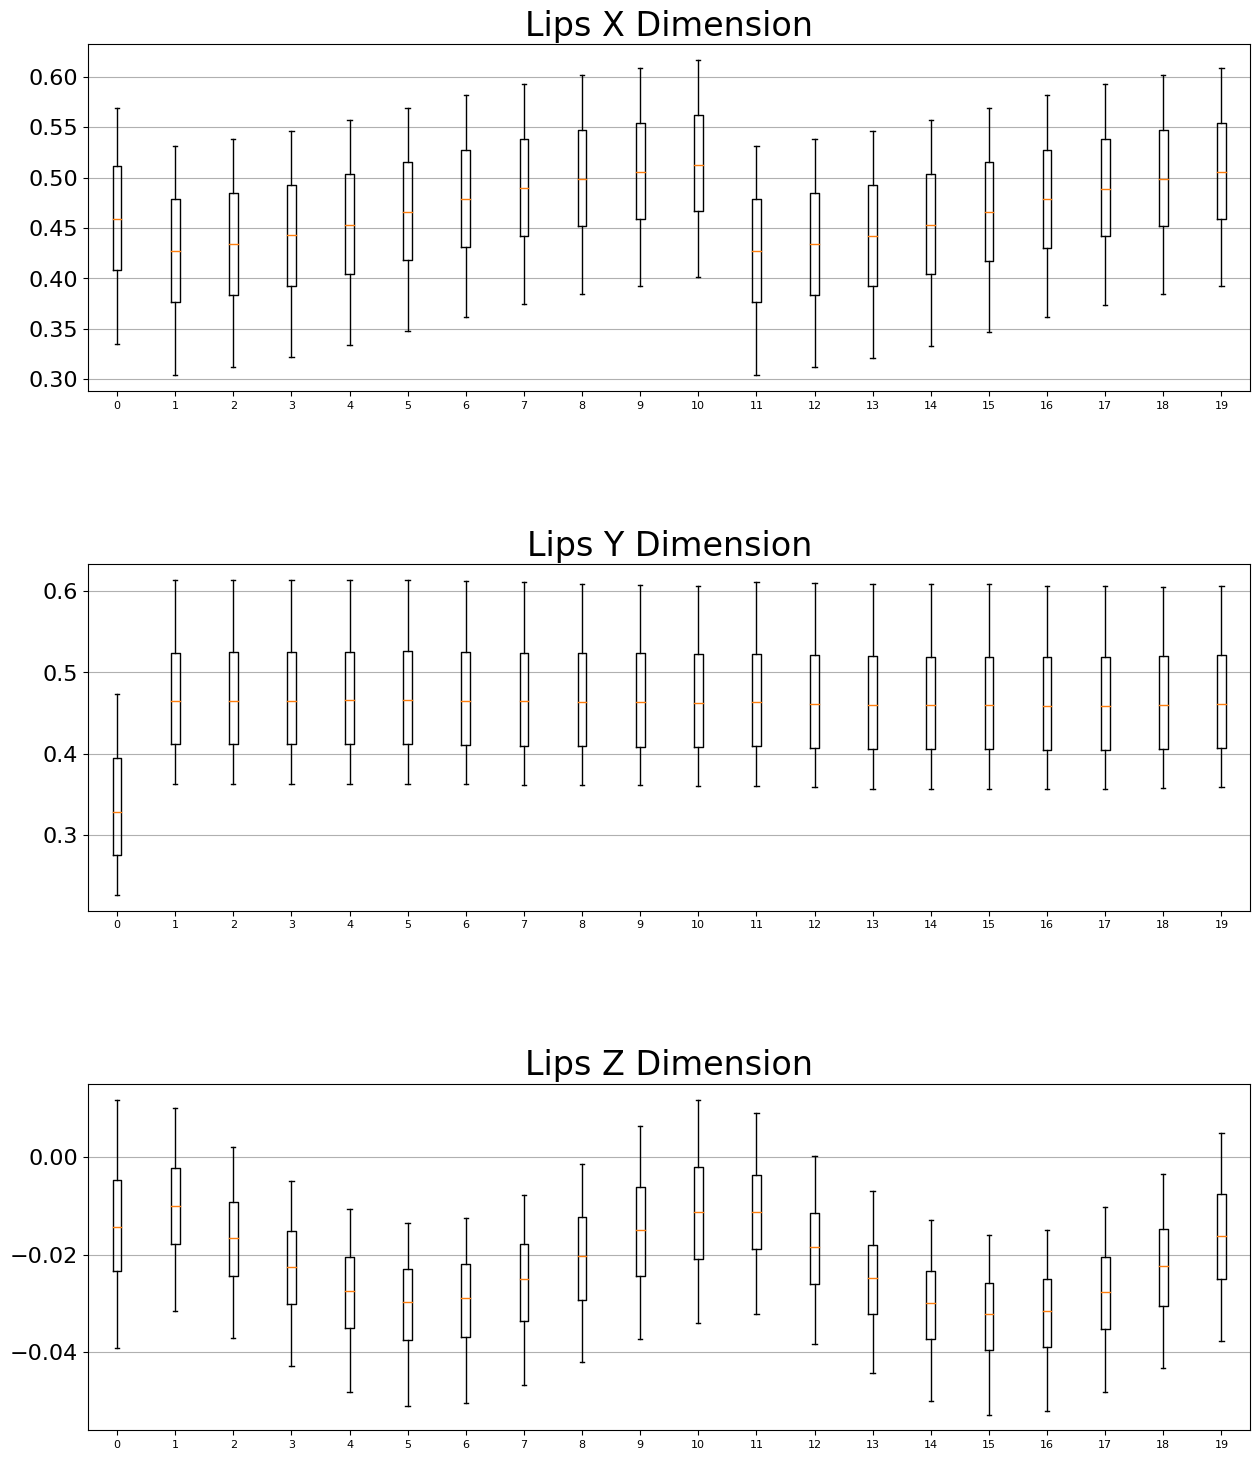

In [20]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

## Feature Statistice - Eyes

In [21]:
# Percentage of Lips Measurements
P_EYE_MEASUREMENTS = (X_train[:,:,EYE_IDXS] != 0).sum() / X_train[:,:,EYE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_EYE_MEASUREMENTS: {P_EYE_MEASUREMENTS:.2f}%')

P_EYE_MEASUREMENTS: 99.34%


  0%|          | 0/16 [00:00<?, ?it/s]

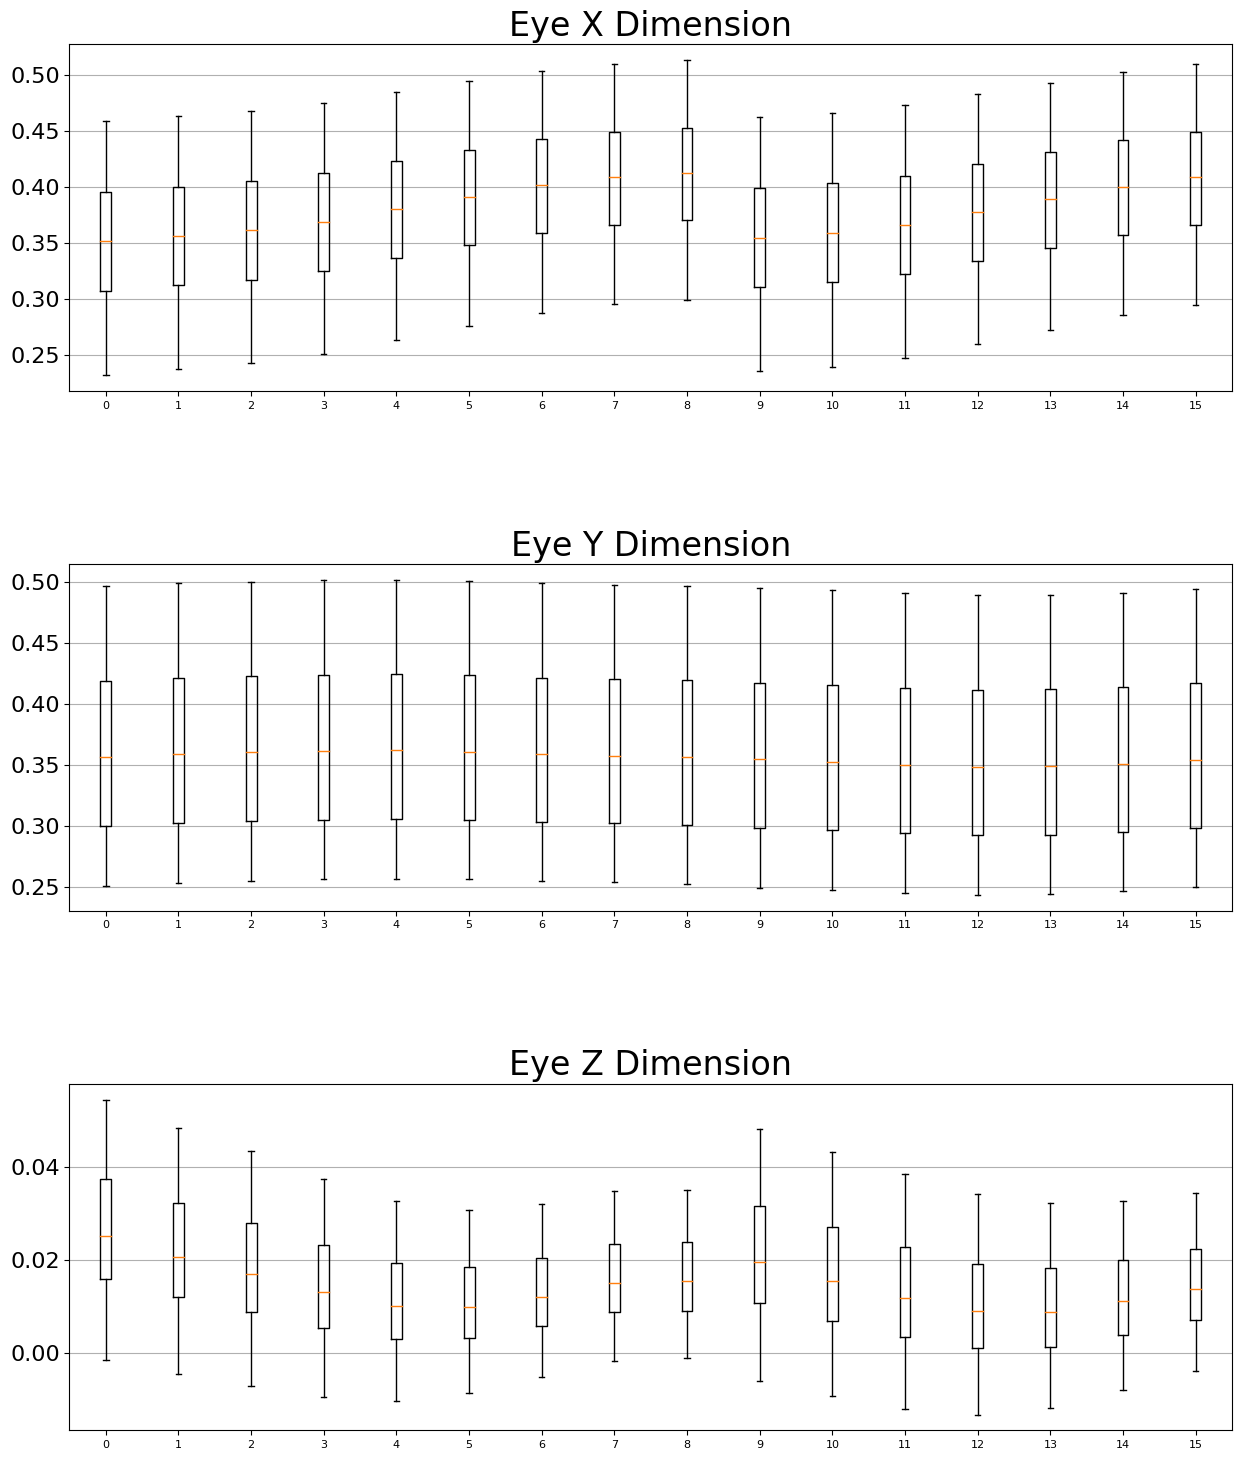

In [22]:
def get_eye_mean_std():
    # EYE
    EYE_MEAN_X = np.zeros([EYE_IDXS.size], dtype=np.float32)
    EYE_MEAN_Y = np.zeros([EYE_IDXS.size], dtype=np.float32)
    EYE_STD_X = np.zeros([EYE_IDXS.size], dtype=np.float32)
    EYE_STD_Y = np.zeros([EYE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,EYE_IDXS], [2,3,0,1]).reshape([EYE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                EYE_MEAN_X[col] = v.mean()
                EYE_STD_X[col] = v.std()
            if dim == 1: # Y
                EYE_MEAN_Y[col] = v.mean()
                EYE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Eye {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    EYE_MEAN = np.array([EYE_MEAN_X, EYE_MEAN_Y]).T
    EYE_STD = np.array([EYE_STD_X, EYE_STD_Y]).T
    
    return EYE_MEAN, EYE_STD

EYE_MEAN, EYE_STD = get_eye_mean_std()

## Feature Statistice - Nose

In [23]:
# Percentage of Nose Measurements
P_NOSE_MEASUREMENTS = (X_train[:,:,NOSE_IDXS] != 0).sum() / X_train[:,:,NOSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_NOSE_MEASUREMENTS: {P_NOSE_MEASUREMENTS:.2f}%')

P_NOSE_MEASUREMENTS: 99.34%


  0%|          | 0/4 [00:00<?, ?it/s]

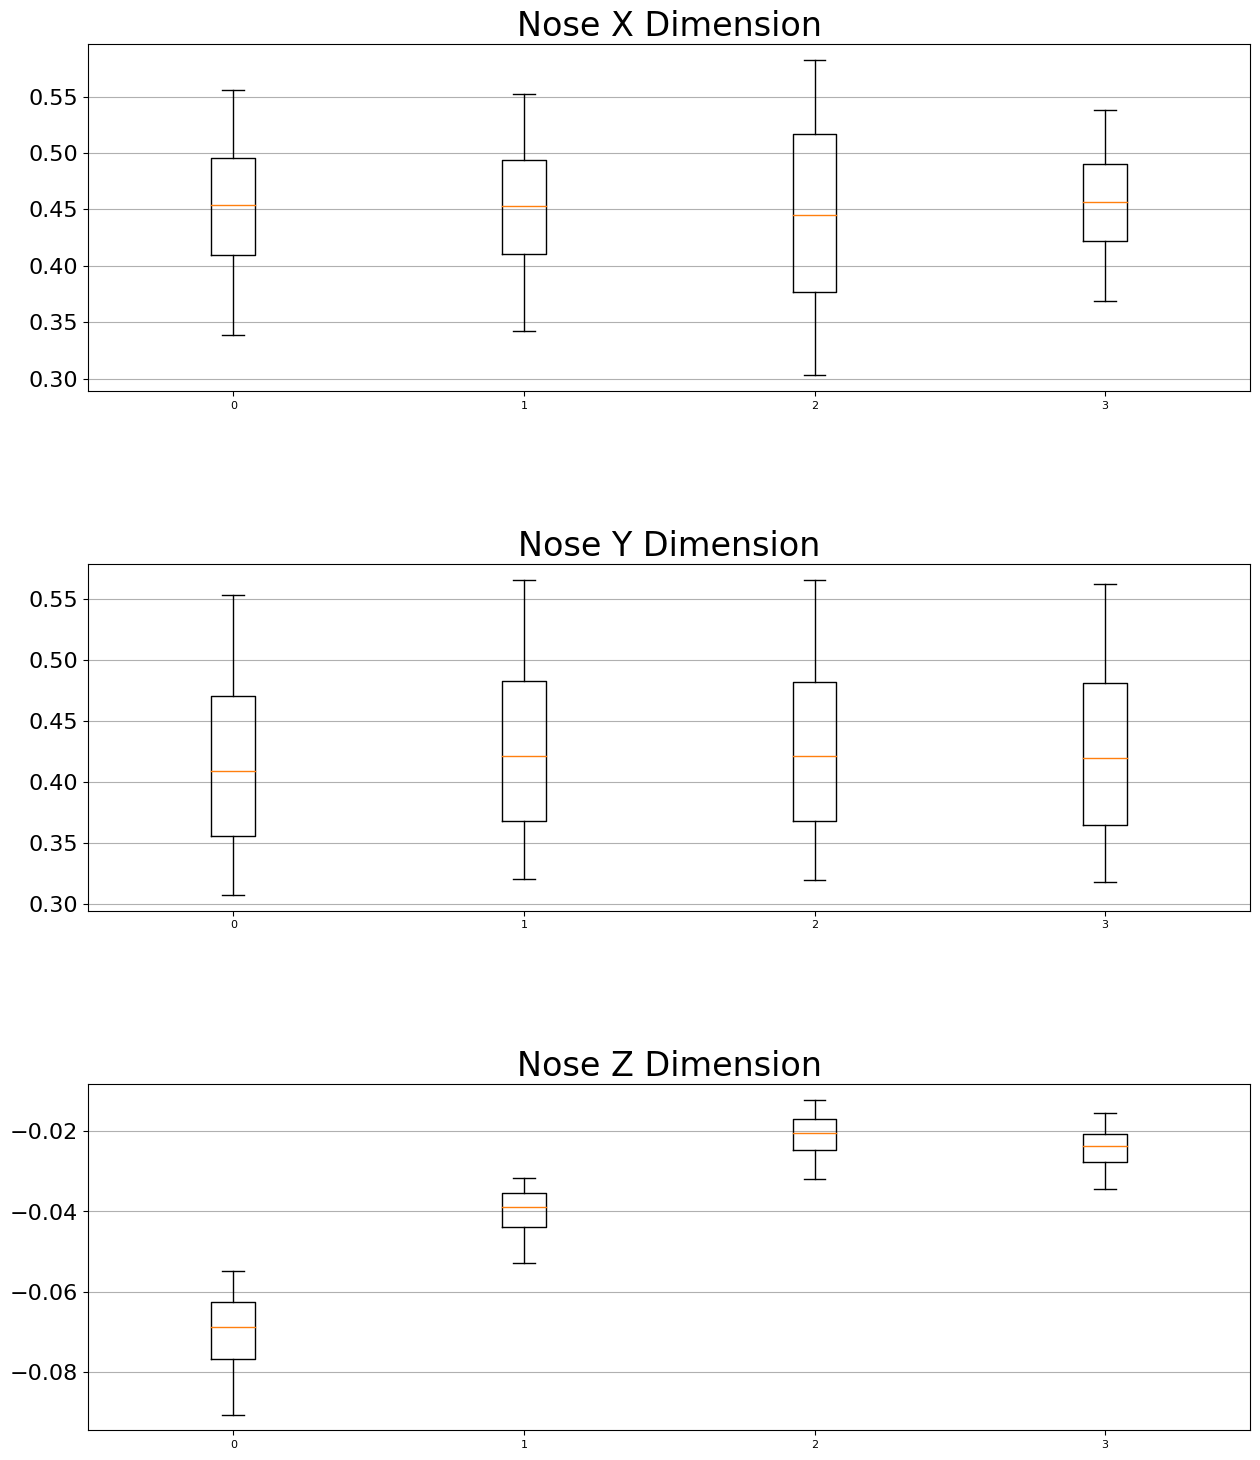

In [24]:
def get_nose_mean_std():
    # Nose
    NOSE_MEAN_X = np.zeros([NOSE_IDXS.size], dtype=np.float32)
    NOSE_MEAN_Y = np.zeros([NOSE_IDXS.size], dtype=np.float32)
    NOSE_STD_X = np.zeros([NOSE_IDXS.size], dtype=np.float32)
    NOSE_STD_Y = np.zeros([NOSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,NOSE_IDXS], [2,3,0,1]).reshape([NOSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                NOSE_MEAN_X[col] = v.mean()
                NOSE_STD_X[col] = v.std()
            if dim == 1: # Y
                NOSE_MEAN_Y[col] = v.mean()
                NOSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Nose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    NOSE_MEAN = np.array([NOSE_MEAN_X, NOSE_MEAN_Y]).T
    NOSE_STD = np.array([NOSE_STD_X, NOSE_STD_Y]).T
    
    return NOSE_MEAN, NOSE_STD

NOSE_MEAN, NOSE_STD = get_nose_mean_std()

## Feature Statistice - Hands

In [25]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

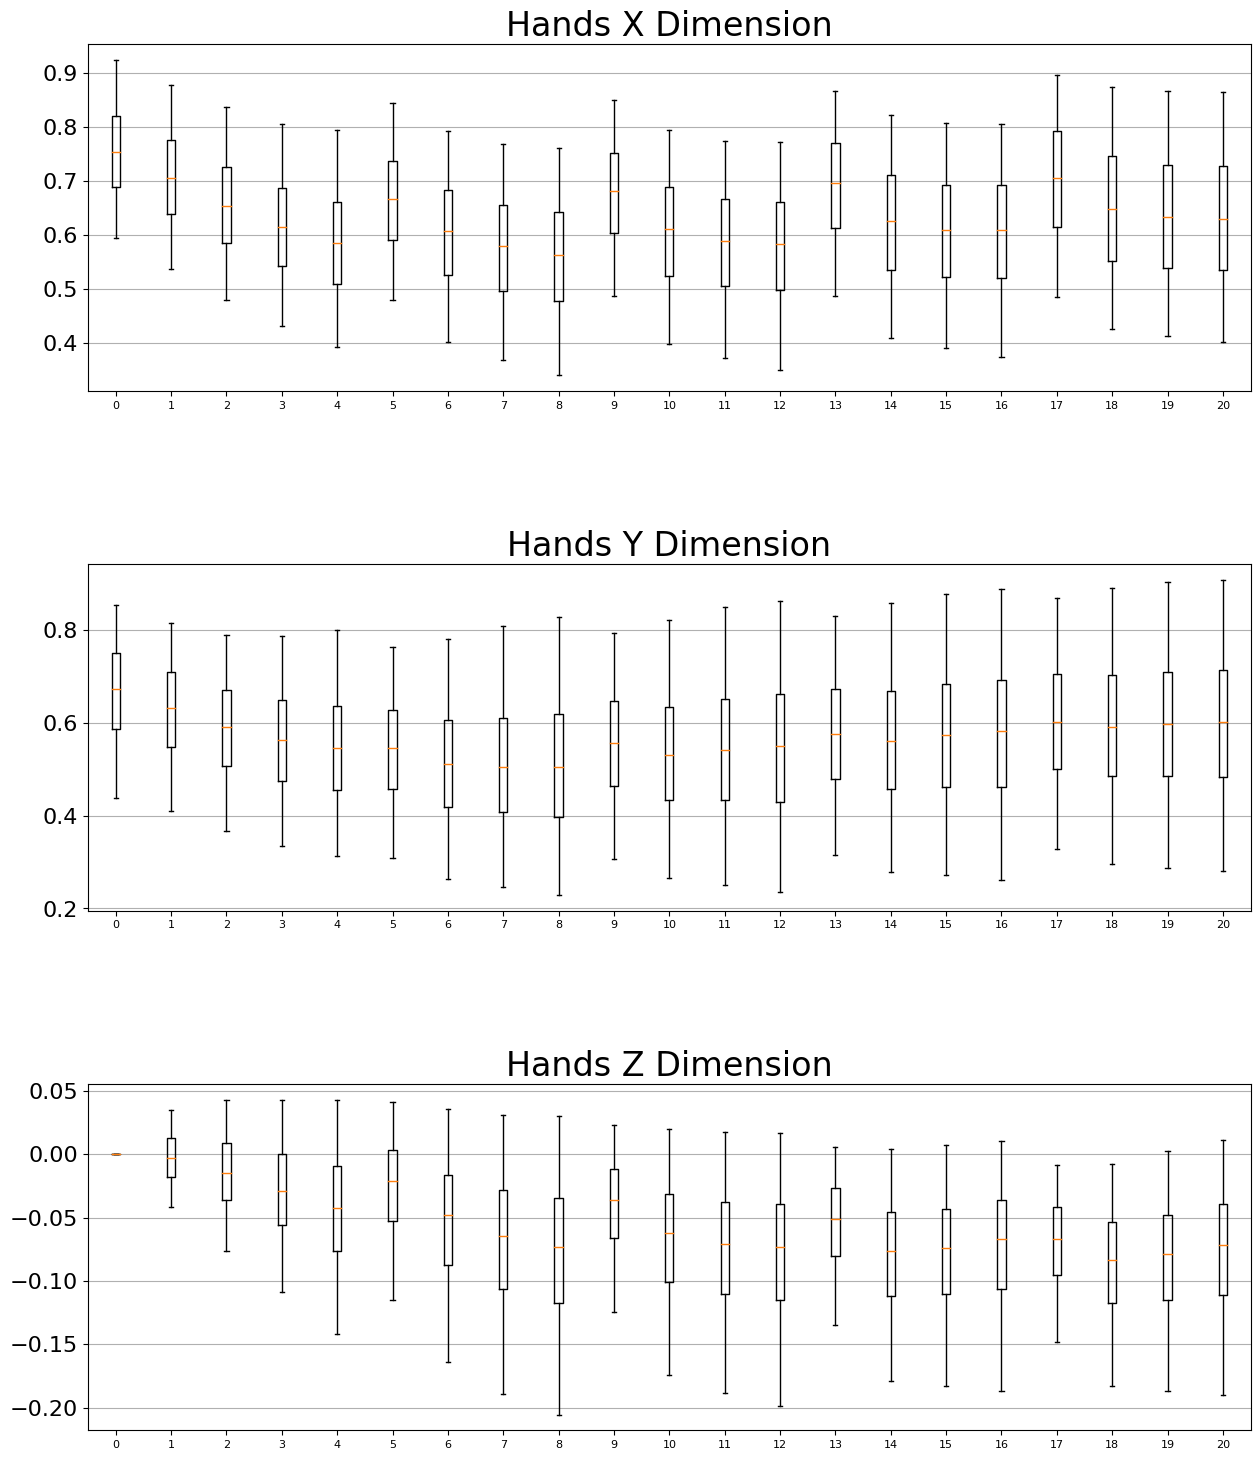

In [26]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

## Feature Statics - Pose

In [27]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/5 [00:00<?, ?it/s]

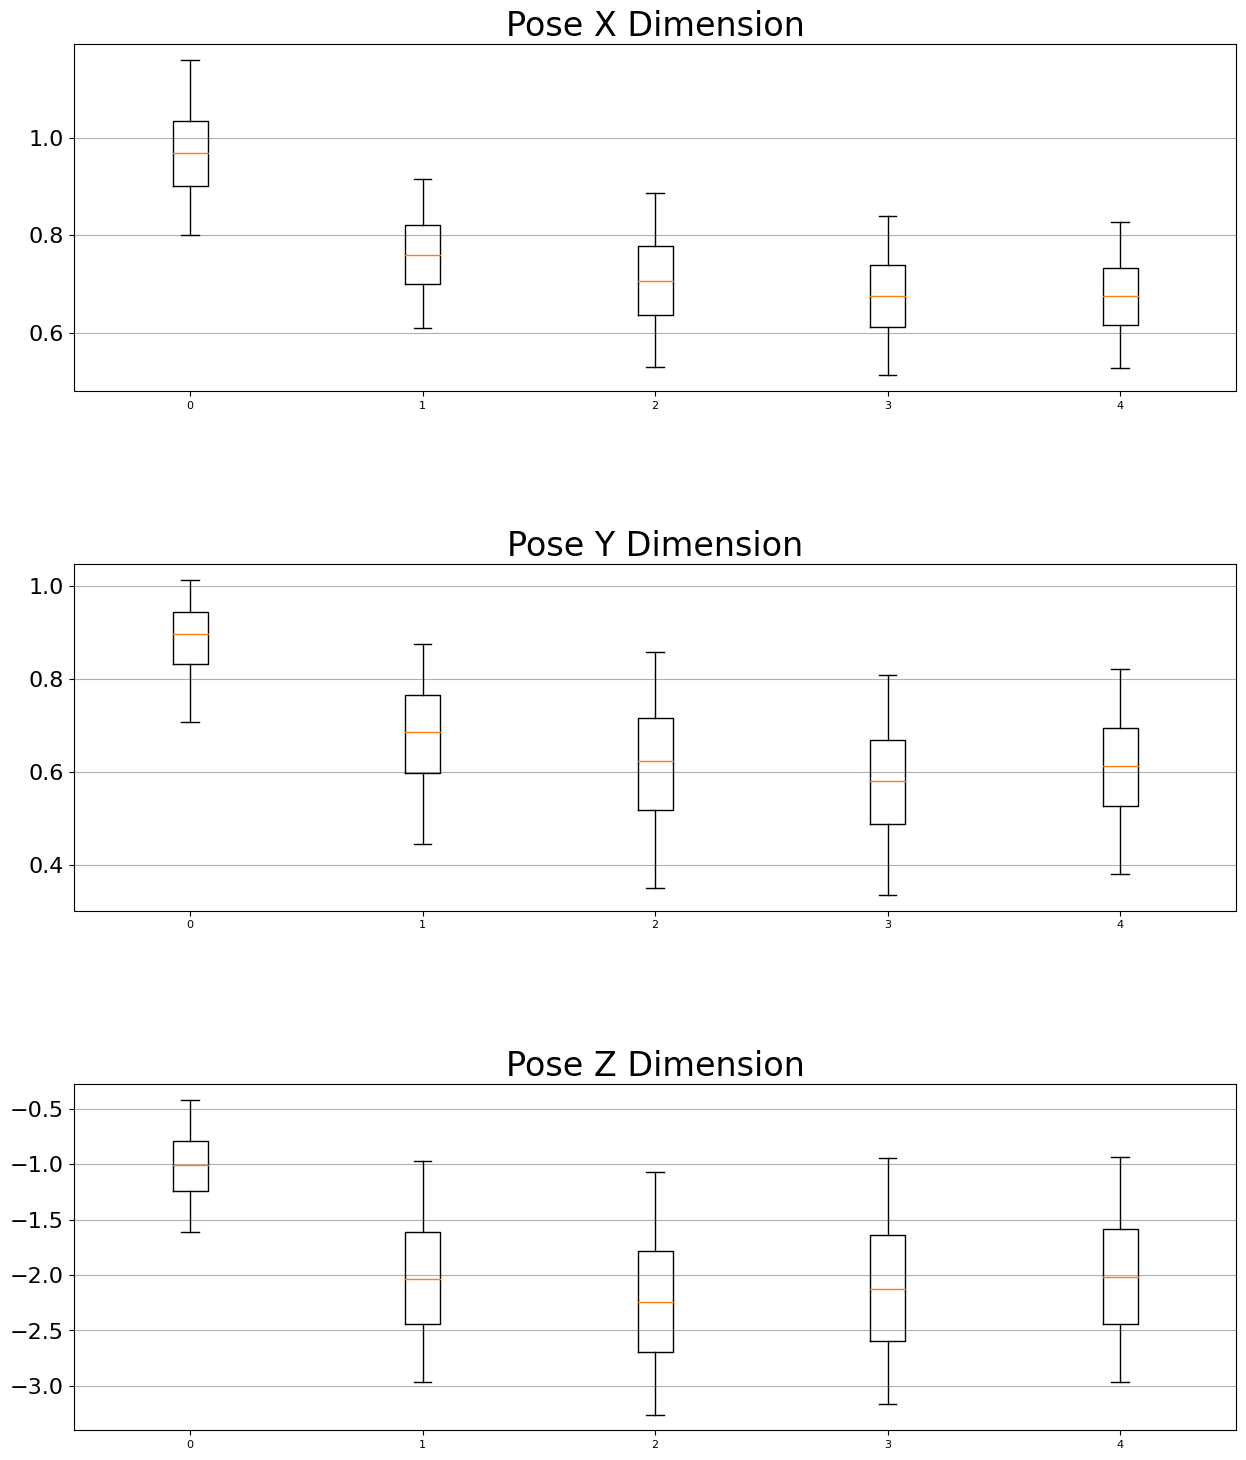

In [28]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

## Samples

In [29]:
## dataset
class gen_dataset(Dataset):
    def __init__(self, X, y, NON_EMPTY_FRAME_IDXS):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.non_empty_frame_idxs = NON_EMPTY_FRAME_IDXS.astype(np.float32)
        
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.non_empty_frame_idxs[idx]

In [30]:
if USE_VAL:
    CLASS2IDXS_train = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS_train[i] = np.argwhere(y_train == i).squeeze().astype(np.int32)

    CLASS2IDXS_val = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS_val[i] = np.argwhere(y_val == i).squeeze().astype(np.int32)
else:   
    CLASS2IDXS_train = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS_train[i] = np.argwhere(y_train == i).squeeze().astype(np.int32)
    

In [31]:
if USE_VAL:
    class_weights = {i:1/len(CLASS2IDXS_train[i]) for i in range(NUM_CLASSES)}
    samples_weight = np.array([class_weights[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
    ## train dataset용
    sampler = WeightedRandomSampler(weights=torch.DoubleTensor(samples_weight), num_samples=len(samples_weight), replacement=True)
    train_dataset = gen_dataset(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
    val_dataset = gen_dataset(X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL)
else:
    ## train all
    class_weights = {i:1/len(CLASS2IDXS_train[i]) for i in range(NUM_CLASSES)}
    samples_weight = np.array([class_weights[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(weights=torch.DoubleTensor(samples_weight), num_samples=len(samples_weight), replacement=True)
    train_dataset = gen_dataset(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)

In [32]:
if USE_VAL:
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, sampler=sampler)
    val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
else:
    ## train all
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, sampler=sampler)

## Modle Config

In [33]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
EYE_UNITS = 384
NOSE_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_OF_HEADS= 16
NUM_BLOCKS = 1
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

## Landmrak Embedding

In [34]:
class LandmarkEmbedding(nn.Module):
    def __init__(self, units, name, input_dim, INPUT_SIZE):
        super(LandmarkEmbedding, self).__init__()
        self.units = units
        self.name = name
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = nn.Parameter(torch.zeros(INPUT_SIZE, self.units), requires_grad=False)
        # Embedding
        self.dense = nn.Sequential(
            nn.Linear(input_dim, self.units),
            nn.ReLU(),
            nn.Linear(self.units, self.units)
        )

        nn.init.xavier_uniform_(self.dense[0].weight)
        nn.init.kaiming_uniform_(self.dense[2].weight)
    
    def forward(self, x):
        return torch.where(
            # Checks whether landmark is missing in frame
            torch.sum(x, dim=2, keepdim=True) == 0,
            # If so, the empty embedding is used
            self.empty_embedding,
            # Otherwise the landmark data is embedded
            self.dense(x),
        )

## Embedding

In [35]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()

        self.positional_embedding = nn.Embedding(INPUT_SIZE+1, UNITS)
        nn.init.zeros_(self.positional_embedding.weight)
        
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips', 80, INPUT_SIZE)
        self.eyes_embedding = LandmarkEmbedding(EYE_UNITS, 'eyes', 64, INPUT_SIZE)
        self.noses_embedding = LandmarkEmbedding(NOSE_UNITS, 'noses', 16, INPUT_SIZE)
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand', 84, INPUT_SIZE)
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose', 20, INPUT_SIZE)
        
        self.landmark_weights = nn.Parameter(torch.zeros([5], dtype=torch.float32), requires_grad=True)
        
        self.fc = nn.Sequential(
            nn.Linear(LIPS_UNITS, UNITS),
            nn.ReLU(),
            nn.Linear(UNITS, UNITS)
        )

        nn.init.xavier_uniform_(self.fc[0].weight)
        nn.init.kaiming_uniform_(self.fc[2].weight)

    def get_diffs(self, l):
        S = l.shape[2]
        other = torch.unsqueeze(l, 3)
        other = other.repeat(1, 1, 1, S)
        other = torch.transpose(other, 2, 3)
        diffs = torch.unsqueeze(l, 3) - other
        diffs = torch.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def forward(self, lips0, eyes0, noses0, left_hand0, pose0, non_empty_frame_idxs):
        lips_embedding = self.lips_embedding(lips0)
        eyes_embedding = self.eyes_embedding(eyes0)
        noses_embedding = self.noses_embedding(noses0)
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        pose_embedding = self.pose_embedding(pose0)

        
        x = torch.stack((lips_embedding, eyes_embedding, noses_embedding, left_hand_embedding, pose_embedding), dim=3)
        x = x * F.softmax(self.landmark_weights, dim=0)
        x = torch.sum(x, dim=3)
  
        
        x = self.fc(x)
        
        normalised_non_empty_frame_idxs = torch.where(
            torch.eq(non_empty_frame_idxs, -1.0),
            torch.tensor(INPUT_SIZE, dtype=torch.int32).cuda(),
            (torch.floor_divide(
                non_empty_frame_idxs, torch.max(non_empty_frame_idxs, dim=1, keepdim=True).values) * INPUT_SIZE).cuda(),
        ).to(torch.int64)
        
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
       
        return x

## Transformer

In [36]:
def scaled_dot_product(q,k,v, attention_mask):
    #calculates Q . K(transpose)
    qkt = torch.matmul(q,k.transpose(-1,-2))
    #caculates scaling factor
    dk = torch.sqrt(torch.tensor(q.shape[-1],dtype=torch.float32))
    scaled_qkt = qkt/dk
    softmax = F.softmax(scaled_qkt.masked_fill(attention_mask == 0, -1e9), dim=-1)
    
    z = torch.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(torch.nn.Module):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = torch.nn.ModuleList([torch.nn.Linear(d_model, self.depth) for i in range(num_of_heads)])
        self.wk = torch.nn.ModuleList([torch.nn.Linear(d_model, self.depth) for i in range(num_of_heads)])
        self.wv = torch.nn.ModuleList([torch.nn.Linear(d_model, self.depth) for i in range(num_of_heads)])
        self.wo = torch.nn.Linear(num_of_heads*self.depth,d_model)
        
    def forward(self,x, attention_mask):
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, attention_mask))
        
        multi_head = torch.cat(multi_attn, dim=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [37]:
class Transformer(torch.nn.Module):
    def __init__(self, num_blocks, UNITS, NUM_CLASSES):
        super(Transformer, self).__init__()
        
        self.Embedding = Embedding()
        
        self.num_blocks = num_blocks
       
        # Multi Head Attention
        self.mhas = torch.nn.ModuleList([MultiHeadAttention(UNITS, NUM_OF_HEADS) for i in range(num_blocks)])
        # Multi Layer Perception
        self.mlps = torch.nn.ModuleList([torch.nn.Sequential(
            torch.nn.Linear(UNITS, UNITS * MLP_RATIO),
            torch.nn.ReLU(),
            torch.nn.Dropout(MLP_DROPOUT_RATIO),
            torch.nn.Linear(UNITS * MLP_RATIO, UNITS),
        ) for i in range(num_blocks)])
        
        nn.init.xavier_uniform_(self.mlps[0][0].weight)
        nn.init.kaiming_uniform_(self.mlps[0][3].weight)
        
        self.dropout = nn.Dropout(p=CLASSIFIER_DROPOUT_RATIO)
        
        self.fc = nn.Linear(UNITS, NUM_CLASSES)

        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x, attention_mask):
        x = self.Embedding(x[0], x[1], x[2], x[3], x[4], x[5])
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x =x + mlp(x)
            
        # Pooling
        x = torch.sum(x * attention_mask, axis=1) / torch.sum(attention_mask, axis=1)
        # Dropout
        x = self.dropout(x)
        # Classification Layer
        x = self.fc(x)
        return x

## Train

In [38]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_max, num_cycles, n_warmup_steps, num_training_steps):
        self._optimizer = optimizer
        self.lr_max = lr_max
        self.num_cycles = num_cycles
        self.n_warmup_steps = n_warmup_steps
        self.num_training_steps = num_training_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        if self.n_steps < self.n_warmup_steps:
            if WARMUP_METHOD == 'log':
                return self.lr_max * 0.10 ** (self.n_warmup_steps - self.n_steps)
            else:
                return self.lr_max * 2 ** -(self.n_warmup_steps - self.n_steps)
        else:
            process = float(self.n_steps - self.n_warmup_steps) / float(max(1, self.num_training_steps - self.n_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(self.num_cycles) * 2.0 * process))) * self.lr_max


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [39]:
model = Transformer(NUM_BLOCKS, UNITS, NUM_CLASSES).cuda()

In [40]:
ssl_path = "./log/ssl_hwc_l_trans/num_block_1_head_16/pretrain/seed_42/all_train/Epoch_99_Val_Loss_0.0000.pth"

from collections import OrderedDict
checkpoint = torch.load(ssl_path, map_location=lambda storage, loc: storage).state_dict()
new_state_dict = OrderedDict()
for n, v in checkpoint.items():
    if n == 'fc.weight' or n == 'fc.bias':
        continue
    else:
        name = n.replace("net.", "")  # .module이 중간에 포함된 형태라면 (".module","")로 치환
        new_state_dict[name] = v

In [41]:
model.load_state_dict(new_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [42]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [43]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_MAX, weight_decay=WD_RATIO)
max_grad_norm = 1.0

## Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
lr_max = LR_MAX
num_cycles = 0.5
n_warmup_steps = N_WARMUP_EPOCHS 
num_training_steps = N_EPOCHS * len(train_dataloader)
scheduler = ScheduledOptim(optimizer, lr_max, num_cycles, n_warmup_steps, num_training_steps)

swa_model = torch.optim.swa_utils.AveragedModel(model)

swa_start = SWA_START

swa_scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_epochs=SWA_ANNEAL_EPOCH, swa_lr=SWA_LR)

In [44]:
import wandb

In [45]:
def do_random_affine_xy(feat,
    scale  = (0.8,1.1),
    shift  = (-1.0,1.0),
    degree = None,
    p=0.3
):
    if np.random.rand()<p:
        if scale is not None:
            xscale = np.random.uniform(*scale)
            yscale = np.random.uniform(*scale)
            feat[...,0] = xscale*feat[...,0]
            feat[...,1] = yscale*feat[...,1]

        if shift is not None:
            xshift = np.random.uniform(*shift)
            yshift = np.random.uniform(*shift)
            feat[...,0] = xshift*feat[...,0]
            feat[...,1] = yshift*feat[...,1]
            
        if degree is not None:
            
            degree = np.random.uniform(*degree)
            radian = degree/180*np.pi
            c = np.cos(radian)
            s = np.sin(radian)
            rotate = np.array([
                [c,-s],
                [s, c],
            ]).T
            feat[...,:2] = feat[...,:2] @rotate
            
    return feat

In [46]:
run = wandb.init(project=PROJECT_NAME)
wandb.run.name = EXP_NAME
for epoch in range(N_EPOCHS):
    if epoch < 30:
        model.dropout.p = 0.0
    elif 30 <= epoch < 60:
        model.dropout.p = 0.25
    elif 60 <= epoch:
        model.dropout.p = 0.50
    model.train()

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    for idx, (X_batch, y_batch, non_empty_frame_idxs_batch) in enumerate(train_dataloader):

        frames = X_batch
        non_empty_frame_idxs = non_empty_frame_idxs_batch
        y = y_batch    


        x = frames
        x = x[:, :INPUT_SIZE, :N_COLS, :2]
        # LIPS
        lips = x[:,:INPUT_SIZE,LIPS_START:LIPS_START+20,:2]
        lips = np.where(
                lips == 0.0,
                0.0,
                (lips - LIPS_MEAN) / LIPS_STD,
            )
        # EYES
        eyes = x[:,:INPUT_SIZE,20:20+16,:2]
        eyes = np.where(
                eyes == 0.0,
                0.0,
                (eyes - EYE_MEAN) / EYE_STD,
            )
        # NOSES
        noses = x[:,:INPUT_SIZE,36:36+4,:2]
        noses = np.where(
                noses == 0.0,
                0.0,
                (noses - NOSE_MEAN) / NOSE_STD,
            )
        # LEFT HAND
        left_hand = x[:,:INPUT_SIZE,40:40+21,:2]
        left_hand = np.where(
                left_hand == 0.0,
                0.0,
                (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
            )


        # POSE
        pose = x[:,:INPUT_SIZE,61:61+5,:2]
        pose = np.where(
                pose == 0.0,
                0.0,
                (pose - POSE_MEAN) / POSE_STD,
            )
        
        mask0 = torch.ne(non_empty_frame_idxs, -1).float()
        mask0 = torch.unsqueeze(mask0, dim=2)
        
        mask0_index = torch.argwhere(mask0[:,:,0] == 1)
        one0_indexs = [mask0_index[mask0_index[:,0] == i,1] for i in range(mask0.shape[0])]
        
        ## add augmentation
        for idx, one_idx in enumerate(one0_indexs): 
            # extract sample index
            one_idx = one_idx.cpu().numpy()
            li_sample = lips[idx, one_idx]
            eye_sample = eyes[idx, one_idx]
            nose_sample = noses[idx, one_idx]
            le_sample = left_hand[idx, one_idx]
            po_sample = pose[idx, one_idx]

            li_sample[...,:2] = do_random_affine_xy(li_sample[...,:2])
            eye_sample[...,:2] = do_random_affine_xy(eye_sample[...,:2])
            nose_sample[...,:2] = do_random_affine_xy(nose_sample[...,:2])
            le_sample[...,:2] = do_random_affine_xy(le_sample[...,:2])
            po_sample[...,:2] = do_random_affine_xy(po_sample[...,:2])

            lips[idx,one_idx] = li_sample
            eyes[idx,one_idx] = eye_sample
            noses[idx,one_idx] = nose_sample
            left_hand[idx,one_idx] = le_sample
            pose[idx,one_idx] = po_sample
            
        # add motion feature
        lips_motion = np.pad(lips[:,:-1,...] - lips[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        eyes_motion = np.pad(eyes[:,:-1,...] - eyes[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        noses_motion = np.pad(noses[:,:-1,...] - noses[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        lh_motion = np.pad(left_hand[:,:-1,...] - left_hand[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        pose_motion = np.pad(pose[:,:-1,...] - pose[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])

        lips_feat = np.reshape(lips, [-1, INPUT_SIZE, 20*2])
        eyes_feat = np.reshape(eyes, [-1, INPUT_SIZE, 16*2])
        noses_feat = np.reshape(noses, [-1, INPUT_SIZE, 4*2])
        left_hand_feat = np.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
        pose_feat = np.reshape(pose, [-1, INPUT_SIZE, 5*2])

        lips_motion_feat = np.reshape(lips_motion, [-1, INPUT_SIZE, 20*2])
        eyes_motion_feat = np.reshape(eyes_motion, [-1, INPUT_SIZE, 16*2])
        noses_motion_feat = np.reshape(noses_motion, [-1, INPUT_SIZE, 4*2])
        lh_motion_feat = np.reshape(lh_motion, [-1, INPUT_SIZE, 21*2])
        pose_motion_feat = np.reshape(pose_motion, [-1, INPUT_SIZE, 5*2])

        lips_all_feat = np.concatenate([lips_feat, lips_motion_feat], -1)
        eyes_all_feat = np.concatenate([eyes_feat, eyes_motion_feat], -1)
        noses_all_feat = np.concatenate([noses_feat, noses_motion_feat], -1)
        lh_all_feat = np.concatenate([left_hand_feat, lh_motion_feat], -1)
        pose_all_feat = np.concatenate([pose_feat, pose_motion_feat], -1)

        lips = torch.tensor(lips_all_feat).cuda()
        eyes = torch.tensor(eyes_all_feat).cuda()
        noses = torch.tensor(noses_all_feat).cuda()
        left_hand = torch.tensor(lh_all_feat).cuda()
        pose = torch.tensor(pose_all_feat).cuda()
        non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs).cuda()
        y = torch.LongTensor(y).cuda()


        mask0 = torch.ne(non_empty_frame_idxs, -1).float()
        mask0 = torch.unsqueeze(mask0, dim=2)

        # Random Frame Masking
        mask = torch.where(
            (torch.rand(mask0.shape,dtype=torch.float32) > 0.25).cuda() & torch.ne(mask0, 0.0).cuda(),
            torch.tensor(1.0).cuda(),
            torch.tensor(0.0).cuda(),
        )
        # Correct Samples Which are all masked now...
        mask = torch.where(
            torch.eq(torch.sum(mask, axis=[1,2], keepdims=True), 0.0),
            torch.tensor(mask0).cuda(),
            torch.tensor(mask).cuda(),
        )
        
        mask_index = torch.argwhere(mask[:,:,0] == 1)
        one_indexs = [mask_index[mask_index[:,0] == i,1] for i in range(mask.shape[0])]


        for idx, one_idx in enumerate(one_indexs): 
            # extract sample index
            li_sample = lips[idx, one_idx]
            eye_sample = eyes[idx, one_idx]
            nose_sample = noses[idx, one_idx]
            le_sample = left_hand[idx, one_idx]
            po_sample = pose[idx, one_idx]

            if torch.rand(1)[0] < 0.3: torch.flip(li_sample,dims=[1]) # add xy scale 
            if torch.rand(1)[0] < 0.3: torch.flip(eye_sample,dims=[1]) # add xy scale 
            if torch.rand(1)[0] < 0.3: torch.flip(nose_sample,dims=[1]) # add xy scale 
            if torch.rand(1)[0] < 0.3: torch.flip(le_sample,dims=[1]) # add xy scale 
            if torch.rand(1)[0] < 0.3: torch.flip(po_sample,dims=[1]) # add xy scale 
            
#             li_sample = do_random_affine(li_sample)
#             le_sample = do_random_affine(le_sample)
#             po_sample = do_random_affine(po_sample)
                
            lips[idx,one_idx] = li_sample
            eyes[idx,one_idx] = eye_sample
            noses[idx,one_idx] = nose_sample
            left_hand[idx,one_idx] = le_sample
            pose[idx,one_idx] = po_sample
        
        x = lips, eyes, noses, left_hand, pose, non_empty_frame_idxs

        # Encoder Transformer Blocks
        y_logit = model(x, mask)
        y_pred = torch.softmax(y_logit, dim=-1)
        loss = criterion(y_logit, y)

        if epoch > swa_start:
            run.log({"lr": swa_scheduler.get_last_lr()})
            scheduler.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scheduler._optimizer.step()
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            run.log({"lr": scheduler._optimizer.param_groups[0]['lr']})
            scheduler.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scheduler.step_and_update_lr()

        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
    if USE_VAL:
        if epoch > swa_start:
            val_loss_sum = 0.
            val_correct = 0
            val_total = 0


            swa_model.eval()
            for idx, (X_batch, y_batch, non_empty_frame_idxs_batch) in enumerate(val_dataloader):

                frames = X_batch
                non_empty_frame_idxs = non_empty_frame_idxs_batch
                y = y_batch    


                x = frames
                x = x[:, :INPUT_SIZE, :N_COLS, :2]
                # LIPS
                lips = x[:,:INPUT_SIZE,LIPS_START:LIPS_START+20,:2]
                lips = np.where(
                        lips == 0.0,
                        0.0,
                        (lips - LIPS_MEAN) / LIPS_STD,
                    )
                # EYES
                eyes = x[:,:INPUT_SIZE,20:20+16,:2]
                eyes = np.where(
                        eyes == 0.0,
                        0.0,
                        (eyes - EYE_MEAN) / EYE_STD,
                    )
                # NOSES
                noses = x[:,:INPUT_SIZE,36:36+4,:2]
                noses = np.where(
                        noses == 0.0,
                        0.0,
                        (noses - NOSE_MEAN) / NOSE_STD,
                    )
                # LEFT HAND
                left_hand = x[:,:INPUT_SIZE,40:40+21,:2]
                left_hand = np.where(
                        left_hand == 0.0,
                        0.0,
                        (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
                    )


                # POSE
                pose = x[:,:INPUT_SIZE,61:61+5,:2]
                pose = np.where(
                        pose == 0.0,
                        0.0,
                        (pose - POSE_MEAN) / POSE_STD,
                    )

                # add motion feature
                lips_motion = np.pad(lips[:,:-1,...] - lips[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                eyes_motion = np.pad(eyes[:,:-1,...] - eyes[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                noses_motion = np.pad(noses[:,:-1,...] - noses[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                lh_motion = np.pad(left_hand[:,:-1,...] - left_hand[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                pose_motion = np.pad(pose[:,:-1,...] - pose[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])

                lips_feat = np.reshape(lips, [-1, INPUT_SIZE, 20*2])
                eyes_feat = np.reshape(eyes, [-1, INPUT_SIZE, 16*2])
                noses_feat = np.reshape(noses, [-1, INPUT_SIZE, 4*2])
                left_hand_feat = np.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
                pose_feat = np.reshape(pose, [-1, INPUT_SIZE, 5*2])

                lips_motion_feat = np.reshape(lips_motion, [-1, INPUT_SIZE, 20*2])
                eyes_motion_feat = np.reshape(eyes_motion, [-1, INPUT_SIZE, 16*2])
                noses_motion_feat = np.reshape(noses_motion, [-1, INPUT_SIZE, 4*2])
                lh_motion_feat = np.reshape(lh_motion, [-1, INPUT_SIZE, 21*2])
                pose_motion_feat = np.reshape(pose_motion, [-1, INPUT_SIZE, 5*2])

                lips_all_feat = np.concatenate([lips_feat, lips_motion_feat], -1)
                eyes_all_feat = np.concatenate([eyes_feat, eyes_motion_feat], -1)
                noses_all_feat = np.concatenate([noses_feat, noses_motion_feat], -1)
                lh_all_feat = np.concatenate([left_hand_feat, lh_motion_feat], -1)
                pose_all_feat = np.concatenate([pose_feat, pose_motion_feat], -1)

                lips = torch.tensor(lips_all_feat).cuda()
                eyes = torch.tensor(eyes_all_feat).cuda()
                noses = torch.tensor(noses_all_feat).cuda()
                left_hand = torch.tensor(lh_all_feat).cuda()
                pose = torch.tensor(pose_all_feat).cuda()
                non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs).cuda()
                y = torch.LongTensor(y).cuda()

                x = lips, eyes, noses, left_hand, pose, non_empty_frame_idxs

                mask = torch.ne(non_empty_frame_idxs, -1).float()
                mask = torch.unsqueeze(mask, dim=2)

                with torch.no_grad():

                    y_logit = swa_model(x, mask)
                    y_pred = torch.softmax(y_logit, dim=-1)
                    loss = criterion(y_logit, y)
                    val_loss_sum += loss.item()
                    val_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
                    val_total += 1


        else:
            val_loss_sum = 0.
            val_correct = 0
            val_total = 0


            model.eval()
            for idx, (X_batch, y_batch, non_empty_frame_idxs_batch) in enumerate(val_dataloader):

                frames = X_batch
                non_empty_frame_idxs = non_empty_frame_idxs_batch
                y = y_batch    


                x = frames
                x = x[:, :INPUT_SIZE, :N_COLS, :2]
                # LIPS
                lips = x[:,:INPUT_SIZE,LIPS_START:LIPS_START+20,:2]
                lips = np.where(
                        lips == 0.0,
                        0.0,
                        (lips - LIPS_MEAN) / LIPS_STD,
                    )
                # EYES
                eyes = x[:,:INPUT_SIZE,20:20+16,:2]
                eyes = np.where(
                        eyes == 0.0,
                        0.0,
                        (eyes - EYE_MEAN) / EYE_STD,
                    )
                # NOSES
                noses = x[:,:INPUT_SIZE,36:36+4,:2]
                noses = np.where(
                        noses == 0.0,
                        0.0,
                        (noses - NOSE_MEAN) / NOSE_STD,
                    )
                # LEFT HAND
                left_hand = x[:,:INPUT_SIZE,40:40+21,:2]
                left_hand = np.where(
                        left_hand == 0.0,
                        0.0,
                        (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
                    )


                # POSE
                pose = x[:,:INPUT_SIZE,61:61+5,:2]
                pose = np.where(
                        pose == 0.0,
                        0.0,
                        (pose - POSE_MEAN) / POSE_STD,
                    )

                # add motion feature
                lips_motion = np.pad(lips[:,:-1,...] - lips[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                eyes_motion = np.pad(eyes[:,:-1,...] - eyes[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                noses_motion = np.pad(noses[:,:-1,...] - noses[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                lh_motion = np.pad(left_hand[:,:-1,...] - left_hand[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
                pose_motion = np.pad(pose[:,:-1,...] - pose[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])

                lips_feat = np.reshape(lips, [-1, INPUT_SIZE, 20*2])
                eyes_feat = np.reshape(eyes, [-1, INPUT_SIZE, 16*2])
                noses_feat = np.reshape(noses, [-1, INPUT_SIZE, 4*2])
                left_hand_feat = np.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
                pose_feat = np.reshape(pose, [-1, INPUT_SIZE, 5*2])

                lips_motion_feat = np.reshape(lips_motion, [-1, INPUT_SIZE, 20*2])
                eyes_motion_feat = np.reshape(eyes_motion, [-1, INPUT_SIZE, 16*2])
                noses_motion_feat = np.reshape(noses_motion, [-1, INPUT_SIZE, 4*2])
                lh_motion_feat = np.reshape(lh_motion, [-1, INPUT_SIZE, 21*2])
                pose_motion_feat = np.reshape(pose_motion, [-1, INPUT_SIZE, 5*2])

                lips_all_feat = np.concatenate([lips_feat, lips_motion_feat], -1)
                eyes_all_feat = np.concatenate([eyes_feat, eyes_motion_feat], -1)
                noses_all_feat = np.concatenate([noses_feat, noses_motion_feat], -1)
                lh_all_feat = np.concatenate([left_hand_feat, lh_motion_feat], -1)
                pose_all_feat = np.concatenate([pose_feat, pose_motion_feat], -1)

                lips = torch.tensor(lips_all_feat).cuda()
                eyes = torch.tensor(eyes_all_feat).cuda()
                noses = torch.tensor(noses_all_feat).cuda()
                left_hand = torch.tensor(lh_all_feat).cuda()
                pose = torch.tensor(pose_all_feat).cuda()
                non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs).cuda()
                y = torch.LongTensor(y).cuda()

                x = lips, eyes, noses, left_hand, pose, non_empty_frame_idxs

                mask = torch.ne(non_empty_frame_idxs, -1).float()
                mask = torch.unsqueeze(mask, dim=2)

                with torch.no_grad():

                    y_logit = model(x, mask)
                    y_pred = torch.softmax(y_logit, dim=-1)
                    loss = criterion(y_logit, y)
                    val_loss_sum += loss.item()
                    val_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
                    val_total += 1

    if USE_VAL:
        wandb.log({"Train Loss": train_loss_sum/(train_total+1), "Train Acc": train_correct/((train_total+1)*(TRAIN_BATCH_SIZE)), \
               "Val Loss": (val_loss_sum/(val_total+1)), "Val Acc": val_correct/((val_total+1)*(VAL_BATCH_SIZE))})
    else:
        wandb.log({"Train Loss": train_loss_sum/(train_total+1), "Train Acc": train_correct/((train_total+1)*(TRAIN_BATCH_SIZE))})
    print(f"Epoch:{epoch} > Train Loss: {(train_loss_sum/(train_total+1)):.04f}, Train Acc: {train_correct/((train_total+1)*(TRAIN_BATCH_SIZE)):0.04f}")
    if USE_VAL:
        print(f"Epoch:{epoch} > Val Loss: {(val_loss_sum/(val_total+1)):.04f}, Val Acc: {val_correct/((val_total+1)*(VAL_BATCH_SIZE)):0.04f}")
    print("="*50)
    if epoch > int(N_EPOCHS*0.8):
        torch.save(swa_model.state_dict(), f"{save_dir}/Epoch_{epoch}.pth")
        
print('--------------perf_swa_model-----------------')
torch.optim.swa_utils.update_bn(train_dataloader, swa_model)
val_loss_sum = 0.
val_correct = 0
val_total = 0

if USE_VAL:
    swa_model.eval()
    for idx, (X_batch, y_batch, non_empty_frame_idxs_batch) in enumerate(val_dataloader):

        frames = X_batch
        non_empty_frame_idxs = non_empty_frame_idxs_batch
        y = y_batch    


        x = frames
        x = x[:, :INPUT_SIZE, :N_COLS, :2]
        # LIPS
        lips = x[:,:INPUT_SIZE,LIPS_START:LIPS_START+20,:2]
        lips = np.where(
                lips == 0.0,
                0.0,
                (lips - LIPS_MEAN) / LIPS_STD,
            )
        # EYES
        eyes = x[:,:INPUT_SIZE,20:20+16,:2]
        eyes = np.where(
                eyes == 0.0,
                0.0,
                (eyes - EYE_MEAN) / EYE_STD,
            )
        # NOSES
        noses = x[:,:INPUT_SIZE,36:36+4,:2]
        noses = np.where(
                noses == 0.0,
                0.0,
                (noses - NOSE_MEAN) / NOSE_STD,
            )
        # LEFT HAND
        left_hand = x[:,:INPUT_SIZE,40:40+21,:2]
        left_hand = np.where(
                left_hand == 0.0,
                0.0,
                (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
            )


        # POSE
        pose = x[:,:INPUT_SIZE,61:61+5,:2]
        pose = np.where(
                pose == 0.0,
                0.0,
                (pose - POSE_MEAN) / POSE_STD,
            )

        # add motion feature
        lips_motion = np.pad(lips[:,:-1,...] - lips[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        eyes_motion = np.pad(eyes[:,:-1,...] - eyes[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        noses_motion = np.pad(noses[:,:-1,...] - noses[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        lh_motion = np.pad(left_hand[:,:-1,...] - left_hand[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])
        pose_motion = np.pad(pose[:,:-1,...] - pose[:,1:,...], [[0,0], [0,1], [0,0], [0,0]])

        lips_feat = np.reshape(lips, [-1, INPUT_SIZE, 20*2])
        eyes_feat = np.reshape(eyes, [-1, INPUT_SIZE, 16*2])
        noses_feat = np.reshape(noses, [-1, INPUT_SIZE, 4*2])
        left_hand_feat = np.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
        pose_feat = np.reshape(pose, [-1, INPUT_SIZE, 5*2])

        lips_motion_feat = np.reshape(lips_motion, [-1, INPUT_SIZE, 20*2])
        eyes_motion_feat = np.reshape(eyes_motion, [-1, INPUT_SIZE, 16*2])
        noses_motion_feat = np.reshape(noses_motion, [-1, INPUT_SIZE, 4*2])
        lh_motion_feat = np.reshape(lh_motion, [-1, INPUT_SIZE, 21*2])
        pose_motion_feat = np.reshape(pose_motion, [-1, INPUT_SIZE, 5*2])

        lips_all_feat = np.concatenate([lips_feat, lips_motion_feat], -1)
        eyes_all_feat = np.concatenate([eyes_feat, eyes_motion_feat], -1)
        noses_all_feat = np.concatenate([noses_feat, noses_motion_feat], -1)
        lh_all_feat = np.concatenate([left_hand_feat, lh_motion_feat], -1)
        pose_all_feat = np.concatenate([pose_feat, pose_motion_feat], -1)

        lips = torch.tensor(lips_all_feat).cuda()
        eyes = torch.tensor(eyes_all_feat).cuda()
        noses = torch.tensor(noses_all_feat).cuda()
        left_hand = torch.tensor(lh_all_feat).cuda()
        pose = torch.tensor(pose_all_feat).cuda()
        non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs).cuda()
        y = torch.LongTensor(y).cuda()

        x = lips, eyes, noses, left_hand, pose, non_empty_frame_idxs

        mask = torch.ne(non_empty_frame_idxs, -1).float()
        mask = torch.unsqueeze(mask, dim=2)

        with torch.no_grad():

            y_logit = swa_model(x, mask)
            y_pred = torch.softmax(y_logit, dim=-1)
            loss = criterion(y_logit, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
            
    print(f"SWA Val Loss: {(val_loss_sum/(val_total+1)):.04f}, SWA Val Acc: {val_correct/((val_total+1)*(VAL_BATCH_SIZE)):0.04f}")
    wandb.log({"SWA Val Loss": (val_loss_sum/(val_total+1)), "SWA Val Acc": val_correct/((val_total+1)*(VAL_BATCH_SIZE))})
torch.save(swa_model.state_dict(), f"{save_dir}/after_bn_Val_Acc_{val_correct/((val_total+1)*(VAL_BATCH_SIZE)):0.04f}_Val_Loss_{(val_loss_sum/(val_total+1)):.04f}.pth")
torch.cuda.empty_cache()     


wandb: Currently logged in as: hwc7. Use `wandb login --relogin` to force relogin


/tmp/ipykernel_426103/1849800205.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs).cuda()
/tmp/ipykernel_426103/1849800205.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mask0).cuda(),
/tmp/ipykernel_426103/1849800205.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mask).cuda(),
/tmp/ipykernel_426103/1849800205.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch:0 > Train Loss: 4.9757, Train Acc: 0.2093
Epoch:0 > Val Loss: 4.3593, Val Acc: 0.4979
Epoch:1 > Train Loss: 4.5693, Train Acc: 0.4140
Epoch:1 > Val Loss: 4.1783, Val Acc: 0.5962
Epoch:2 > Train Loss: 4.4105, Train Acc: 0.4967
Epoch:2 > Val Loss: 4.1277, Val Acc: 0.6245
Epoch:3 > Train Loss: 4.3257, Train Acc: 0.5453
Epoch:3 > Val Loss: 4.0585, Val Acc: 0.6604
Epoch:4 > Train Loss: 4.2663, Train Acc: 0.5797
Epoch:4 > Val Loss: 4.0293, Val Acc: 0.6733
Epoch:5 > Train Loss: 4.2199, Train Acc: 0.6026
Epoch:5 > Val Loss: 4.0219, Val Acc: 0.6772
Epoch:6 > Train Loss: 4.1881, Train Acc: 0.6225
Epoch:6 > Val Loss: 3.9992, Val Acc: 0.6853
Epoch:7 > Train Loss: 4.1513, Train Acc: 0.6414
Epoch:7 > Val Loss: 3.9739, Val Acc: 0.7031
Epoch:8 > Train Loss: 4.1324, Train Acc: 0.6530
Epoch:8 > Val Loss: 3.9852, Val Acc: 0.6968
Epoch:9 > Train Loss: 4.1038, Train Acc: 0.6680
Epoch:9 > Val Loss: 3.9781, Val Acc: 0.6934
Epoch:10 > Train Loss: 4.0822, Train Acc: 0.6792
Epoch:10 > Val Loss: 3.9786, Va

/tmp/ipykernel_426103/1849800205.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs).cuda()


Epoch:71 > Train Loss: 3.8069, Train Acc: 0.8504
Epoch:71 > Val Loss: 3.8874, Val Acc: 0.7433
Epoch:72 > Train Loss: 3.8006, Train Acc: 0.8552
Epoch:72 > Val Loss: 3.8872, Val Acc: 0.7413
Epoch:73 > Train Loss: 3.7981, Train Acc: 0.8550
Epoch:73 > Val Loss: 3.8869, Val Acc: 0.7416
Epoch:74 > Train Loss: 3.7964, Train Acc: 0.8558
Epoch:74 > Val Loss: 3.8866, Val Acc: 0.7422
Epoch:75 > Train Loss: 3.7993, Train Acc: 0.8536
Epoch:75 > Val Loss: 3.8865, Val Acc: 0.7424
Epoch:76 > Train Loss: 3.7973, Train Acc: 0.8561
Epoch:76 > Val Loss: 3.8866, Val Acc: 0.7426
Epoch:77 > Train Loss: 3.7957, Train Acc: 0.8563
Epoch:77 > Val Loss: 3.8866, Val Acc: 0.7425
Epoch:78 > Train Loss: 3.7962, Train Acc: 0.8558
Epoch:78 > Val Loss: 3.8865, Val Acc: 0.7436
Epoch:79 > Train Loss: 3.7946, Train Acc: 0.8556
Epoch:79 > Val Loss: 3.8864, Val Acc: 0.7436
Epoch:80 > Train Loss: 3.7923, Train Acc: 0.8572
Epoch:80 > Val Loss: 3.8863, Val Acc: 0.7440
Epoch:81 > Train Loss: 3.7935, Train Acc: 0.8563
Epoch:81 > 

/tmp/ipykernel_426103/1849800205.py:494: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs).cuda()


SWA Val Loss: 3.8881, SWA Val Acc: 0.7432
